In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import RandomForest
from darts.models import XGBModel
from darts.models import Prophet
from darts.models import LightGBMModel
from darts import concatenate
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../Data/Kaggle/StoreSales/flask.csv", parse_dates=["date"])

In [3]:
df.head()

,date,store_nbr,family,sales,onpromotion,typeholiday,dcoilwtico,day_of_week,day,month,year
0,2013-01-01,1,0,0.0,0,3,93.14,2,1,1,2013
1,2013-01-01,1,1,0.0,0,3,93.14,2,1,1,2013
2,2013-01-01,1,2,0.0,0,3,93.14,2,1,1,2013
3,2013-01-01,1,3,0.0,0,3,93.14,2,1,1,2013
4,2013-01-01,1,4,0.0,0,3,93.14,2,1,1,2013


In [4]:
df = df[(df['store_nbr'] == 8) & (df['family'] == 30)]

In [5]:
df.head()

,date,store_nbr,family,sales,onpromotion,typeholiday,dcoilwtico,day_of_week,day,month,year
1746,2013-01-01,8,30,0.0,0,3,93.140000,2,1,1,2013
3528,2013-01-02,8,30,0.0,0,4,93.140000,3,2,1,2013
5310,2013-01-03,8,30,0.0,0,4,92.970000,4,3,1,2013
7092,2013-01-04,8,30,0.0,0,4,93.120000,5,4,1,2013
8874,2013-01-05,8,30,0.0,0,4,93.159203,6,5,1,2013


In [6]:
dcoilwtico_ts = TimeSeries.from_dataframe(df, value_cols=["dcoilwtico"])
onpromotion_ts = TimeSeries.from_dataframe(df, value_cols=["onpromotion"])
typeholiday_ts = TimeSeries.from_dataframe(df, value_cols=["typeholiday"])
day_of_week_ts = TimeSeries.from_dataframe(df, value_cols=["day_of_week"])
day_ts = TimeSeries.from_dataframe(df, value_cols=["day"])
month_ts = TimeSeries.from_dataframe(df, value_cols=["month"])
year_ts = TimeSeries.from_dataframe(df, value_cols=["year"])

In [7]:
future_cov = concatenate([dcoilwtico_ts,
                          onpromotion_ts,
                          typeholiday_ts,
                          day_of_week_ts,
                          day_ts,
                          month_ts,
                          year_ts], axis=1)

In [8]:
ts = TimeSeries.from_dataframe(df, value_cols=["sales"])

In [9]:
training_size = len(ts) - 30

In [10]:
train = ts[:training_size]
val = ts[training_size:]

In [11]:
val = val.pd_series().tolist()

In [12]:
len_future_covariates = len(val)
future_covariates_lags = list(range(len_future_covariates))

Random Forest (RMSE): 515.1569050225692
Root Mean Squared Logarithmic Error (RMSLE): 0.10922041365938666


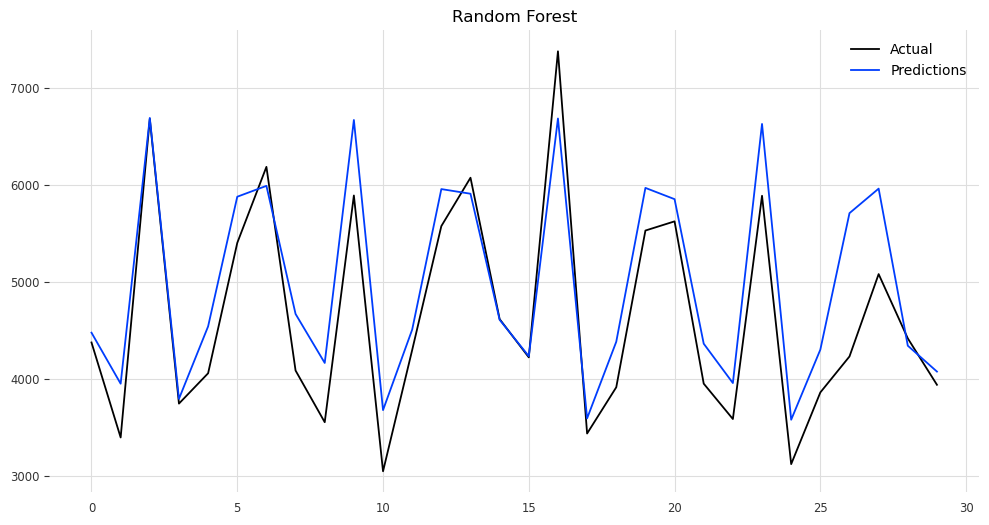

In [13]:
model_rf = RandomForest(lags=2, lags_future_covariates=future_covariates_lags, output_chunk_length=30)
model_rf.fit(train, future_covariates=future_cov)
predictions_rf = model_rf.predict(n=len(val))
predictions_rf = predictions_rf.pd_series().tolist()
predictions_rf = np.maximum(predictions_rf, 0)
rmse_rf = np.sqrt(mean_squared_error(val, predictions_rf))
rmsle_rf = np.sqrt(mean_squared_error(np.log1p(val), np.log1p(predictions_rf)))
print(f"Random Forest (RMSE): {rmse_rf}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_rf}")
plt.figure(figsize=(12, 6))
plt.plot(val, label='Actual')
plt.plot(predictions_rf, label='Predictions')
plt.title(f"Random Forest")
plt.legend()
plt.show()

XGBoost (RMSE): 471.45096677244555
XGBoost (RMSLE): 0.10075316677686665


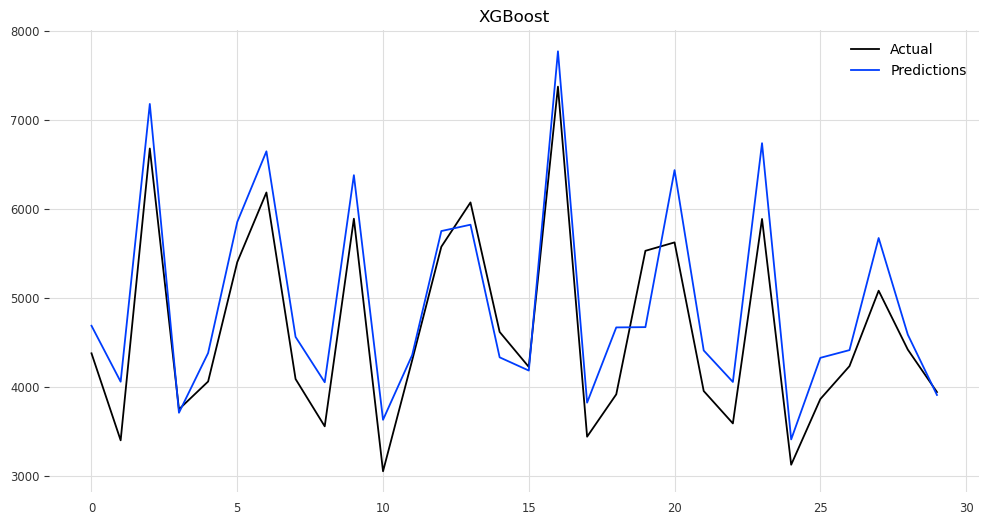

In [14]:
model_xgb = XGBModel(lags=2, lags_future_covariates=future_covariates_lags, output_chunk_length=30)
model_xgb.fit(train, future_covariates=future_cov)
predictions_xgb = model_xgb.predict(n=len(val))
predictions_xgb = predictions_xgb.pd_series().tolist()
predictions_xgb = np.maximum(predictions_xgb, 0)
rmse_xgb = np.sqrt(mean_squared_error(val, predictions_xgb))
rmsle_xgb = np.sqrt(mean_squared_error(np.log1p(val), np.log1p(predictions_xgb)))
print(f"XGBoost (RMSE): {rmse_xgb}")
print(f"XGBoost (RMSLE): {rmsle_xgb}")
plt.figure(figsize=(12, 6))
plt.plot(val, label='Actual')
plt.plot(predictions_xgb, label='Predictions')
plt.title(f"XGBoost")
plt.legend()
plt.show()

02:37:50 - cmdstanpy - INFO - Chain [1] start processing
02:37:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet (RMSE): 1261.845451960131
Prophet (RMSLE): 0.2652973609924706


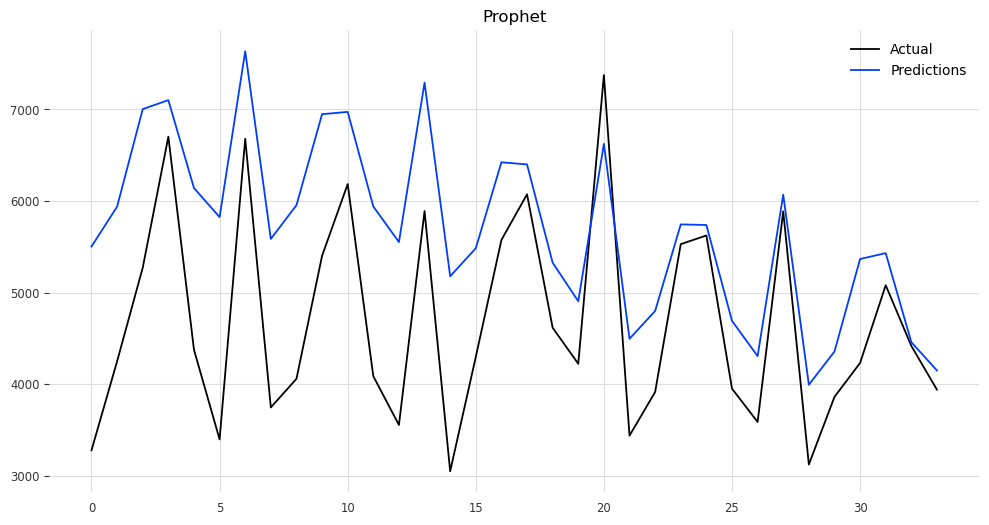

In [15]:
df_p = df.copy()
df_p.set_index('date', inplace=True)
ts_p = TimeSeries.from_dataframe(df_p, value_cols=["sales"], freq='d')
train_p = ts_p[:training_size]
val_p = ts_p[training_size:]
val_p = val_p.pd_series().tolist()
model_p = Prophet()
model_p.fit(train_p)
predictions_p = model_p.predict(n=len(val_p))
predictions_p = predictions_p.pd_series().tolist()
predictions_p = np.maximum(predictions_p, 0)
nan_indices = np.isnan(val_p)
nan_count = np.sum(nan_indices)
if nan_count > 0:
    print(f"There are {nan_count} NaN values in the data.")
val_p = np.nan_to_num(val_p, nan=0.0)
rmse_p = np.sqrt(mean_squared_error(val_p, predictions_p))
rmsle_p = np.sqrt(mean_squared_error(np.log1p(val_p), np.log1p(predictions_p)))
print(f"Prophet (RMSE): {rmse_p}")
print(f"Prophet (RMSLE): {rmsle_p}")
plt.figure(figsize=(12, 6))
plt.plot(val_p, label='Actual')
plt.plot(predictions_p, label='Predictions')
plt.title(f"Prophet")
plt.legend()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11556
[LightGBM] [Info] Number of data points in the train set: 1623, number of used features: 212
[LightGBM] [Info] Start training from score 2998.943139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11556
[LightGBM] [Info] Number of data points in the train set: 1623, number of used features: 212
[LightGBM] [Info] Start training from score 3002.263244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 

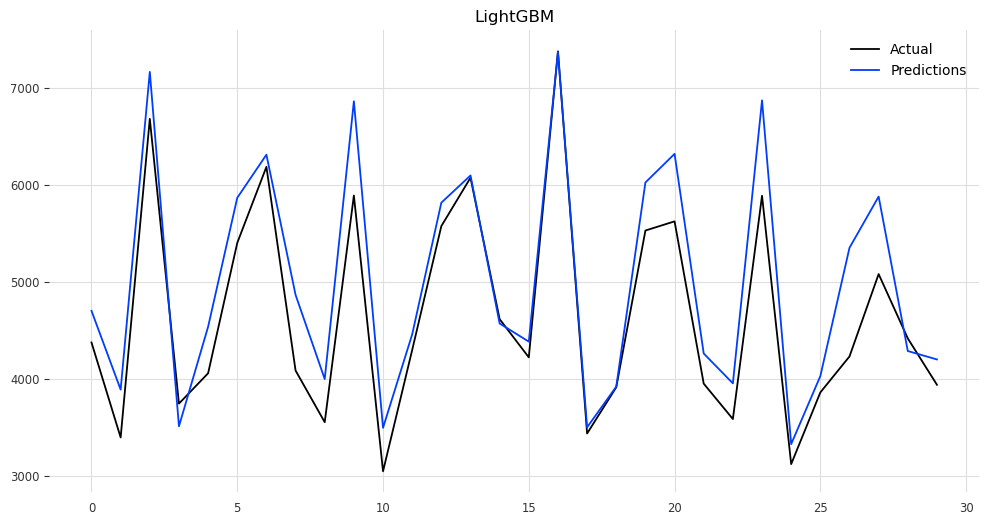

In [16]:
model_lgbm = LightGBMModel(lags=2, lags_future_covariates=future_covariates_lags, output_chunk_length=30)
model_lgbm.fit(train, future_covariates=future_cov)
predictions_lgbm = model_lgbm.predict(n=len(val))
predictions_lgbm = predictions_lgbm.pd_series().tolist()
predictions_lgbm = np.maximum(predictions_lgbm, 0)
rmse_lgbm = np.sqrt(mean_squared_error(val, predictions_lgbm))
rmsle_lgbm = np.sqrt(mean_squared_error(np.log1p(val), np.log1p(predictions_lgbm)))
print(f"LightGBM (RMSE): {rmse_lgbm}")
print(f"LightGBM (RMSLE): {rmsle_lgbm}")
plt.figure(figsize=(12, 6))
plt.plot(val, label='Actual')
plt.plot(predictions_lgbm, label='Predictions')
plt.title(f"LightGBM")
plt.legend()
plt.show()

In [17]:
rmse = min(rmse_rf, rmse_xgb, rmse_p, rmse_lgbm)
rmsle = min(rmsle_rf, rmsle_xgb, rmse_p, rmsle_lgbm)

In [18]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle}")

Root Mean Squared Error (RMSE): 471.45096677244555
Root Mean Squared Logarithmic Error (RMSLE): 0.09851735135672215
